# Network Summary

## Network source and preprocesing

In [152]:
import json, sys
from urllib import request
from copy import copy

In [153]:
import matplotlib.pyplot as plt
import seaborn as sns

In [151]:
import json
import networkx as nx

In [3]:
CLIENT_ID = 56337756
APP_ID = 7379264

In [64]:
with open('data/nodes_data.json','r') as f:
    nodes_data = json.load(f)
with open('data/connections_data.json','r') as f:
    connections_data = json.load(f)

In [65]:
connections_data = {k: [v_ for v_ in v if str(v_) in connections_data.keys()]
                    for k,v in connections_data.items()}

In [66]:
nodes_data = {int(k):v for k,v in nodes_data.items()}
connections_data = {int(k):v for k,v in connections_data.items()}

In [91]:
G = nx.from_dict_of_lists(connections_data)

In [92]:
nx.write_gml(G, 'network.gml')

In [229]:
G = nx.Graph(nx.read_gml('network_prettify_2.gml',))

In [230]:
for k,d in nodes_data.items():
    for k_, v_ in d.items():
        G.nodes[str(k)][k_] = v_

In [231]:
for n in G.nodes:
    G.nodes[n]['pos'] = (G.nodes[n]['graphics']['x'], G.nodes[n]['graphics']['y'])
    #print(n, G.nodes[n])

In [232]:
nodelist = list(G.nodes)

pos = {n: (G.nodes[n]['graphics']['x'], G.nodes[n]['graphics']['y']) for n in nodelist}
sizes = [50 for n in nodelist]
colors_by_city = [{'Moscow':'orange', 'Izhevsk':'green'}.get(G.nodes[n]['city']['title'], 'grey')
        if 'city' in G.nodes[n] else 'grey' for n in nodelist]

In [233]:
import plotly.graph_objects as go

## Node/Edge attributes

node attributes

In [237]:
G.nodes["779564"].keys()

dict_keys(['graphics', 'id', 'first_name', 'last_name', 'sex', 'city', 'university', 'university_name', 'faculty', 'faculty_name', 'graduation', 'education_status', 'online', 'track_code', 'pos'])

## Size, Order

In [238]:
print(f"Order of network: {len(G.nodes)}")
print(f"Size of network: {len(G.edges)}")

Order of network: 245
Size of network: 1901


## Gorgeous network layout

In [240]:
def plotly_graph(G, node_color):
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = G.nodes[node]['pos']
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            # colorscale options
            #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
            #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
            #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
            colorscale='YlGnBu',
            reversescale=True,
            color=[],
            size=10,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))
    
    node_text = [f"<br>".join([f"{k}: {v}" for k,v in G.nodes[n].items()
                              if k not in ['graphics','track_code','pos', 'online']])
                 for n in G.nodes]

    node_trace.marker.color = node_color #node_adjacencies
    node_trace.text = node_text
    
    fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Graph of friends of E. Dudyrev',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
    return fig

In [241]:
fig = plotly_graph(G, node_color=colors_by_city)

In [242]:
fig.show()

## Degree distribution
Diameter, Clustering Coefficient

In [244]:
print(f"Diameter: {nx.diameter(G)}")
print(f"Mean Clustering Coefficient: {nx.cluster.average_clustering(G)}")

Diameter: 2
Mean Clustering Coefficient: 0.6875024013560046


# Structural Analysis

## Degree/Closeness/Betweennes centralities
Top nodes interpretation

In [245]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Degree

In [246]:
degrees = pd.Series(dict(nx.degree(G))).sort_values(ascending=False)
degree_centr = pd.Series(dict(nx.degree_centrality(G))).sort_values(ascending=False)

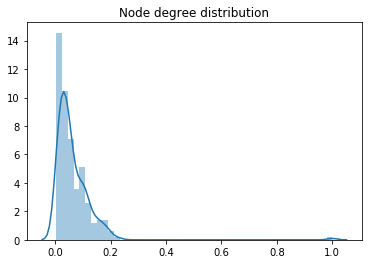

In [247]:
sns.distplot(degree_centr)
plt.title('Node degree distribution')
plt.show()

Интерпретация узлов:
* 1) Я
* 2) (58 общих друзей): Андрей Максименко: Один из лидеров друзей из Ижевска
* 3) (50 общих друзей): Татьяна Вольнова: Другой, формальный, лидер скаутов из Ижевска
* 4) (49 общих друзей): Анастасия Нелидова: В группе с предыдущими друзьями из Ижевска
...
* 27) (31 общий друг): Света Злобина: одногруппница из МГТУ
* 32) (29 общих друзей): Мустангер Шапиев: одногруппник из МГТУ
* 45) (26 общих друзей): Розалия Хафизова: одноклассница

### Closeness

In [248]:
closeness = pd.Series(dict(nx.closeness_centrality(G))).sort_values(ascending=False)

Интерпретация узлов:
* 1) 0,9621 Я
* 2) 0,5582 Андрей Максименко
* 3) 0,5486 Татьяна Волнова
* 4) 0,5474 Анастасия Нелидова
...
* 33) 0,5237 Света Злобина МГТУ 
* 40) 0,5205 Сергей Серов: Староста в МГТУ

### Betweeness

In [249]:
betweeness = pd.Series(nx.betweenness_centrality(G)).sort_values(ascending=False)

In [251]:
idx = 7
idx += 1
idx ,G.nodes[betweeness.index[idx]], round(betweeness.values[idx],4)

(8,
 {'graphics': {'x': -239.58138,
   'y': -220.56425,
   'z': 0.0,
   'w': 10.0,
   'h': 10.0,
   'd': 10.0,
   'fill': '#000000'},
  'id': 10954193,
  'first_name': 'Natalya',
  'last_name': 'Bazhenova',
  'sex': 1,
  'city': {'id': 56, 'title': 'Izhevsk'},
  'university': 503,
  'university_name': 'УдГУ',
  'faculty': 153142,
  'faculty_name': 'Институт естественных наук (бывш. Биолого-химический, Медицинской биотехнологии, Географический)',
  'graduation': 2002,
  'education_form': 'Full-time',
  'education_status': 'Alumna (Specialist)',
  'online': 0,
  'track_code': '3f17911eTMC6Ezel4dbjBCYxXTVEl92OIvNeesqr0ZiqSMRKJdshq7ArB_LmjeJTA-Pk_czzvYM16DsU',
  'pos': (-239.58138, -220.56425)},
 0.0024)

Интерпретация узлов:
* 1) 0.8515 Я
* 2) 0.0096 Андрей Максименко
* 3) 0,0083 Алсу Райская
* 4) 0,0079 Никита Резниченко: Кто это вообще такой?
* 5) 0,0079 Денис Ерёмин: соотрядник из летнего лагеря
...
* 8) 0,0034 Сергей Серов: Староста МГТУ
* 9) 0.0034 Денис Пермяков: Худ. рук одного детского лагеря 

## Page-Rank. Comparison with centralities

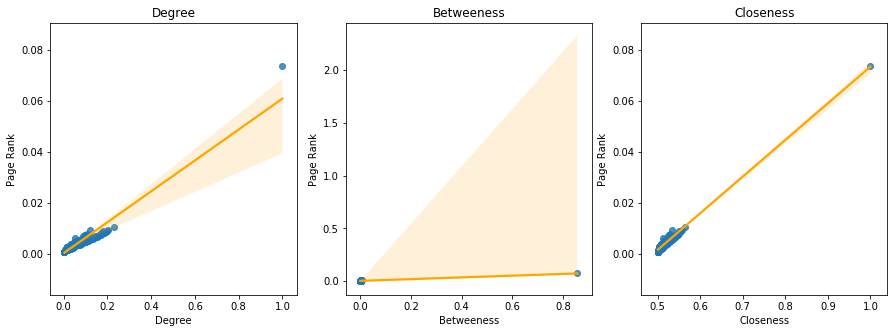

In [252]:
pr = pd.Series(nx.pagerank(G, alpha=0.85))
plt.figure(figsize=(15,5))
for idx, centr in enumerate([('Degree', degree_centr), ('Betweeness', betweeness), ('Closeness', closeness)]):
    plt.subplot(1,3,idx+1)
    title, centr = centr
    sns.regplot(x=centr.sort_index(), y=pr.sort_index(), line_kws={'color':'orange'})
    plt.title(title)
    plt.xlabel(title)
    plt.ylabel('Page Rank')
plt.show()

## Node structural equivalence/similarity

In [253]:
import scipy.spatial as spt

In [254]:
def plotDist(A, figsize=(10,10)):
    f, ax = plt.subplots(2, 2, figsize=figsize)
    ax[0, 0].imshow(A, cmap = 'Greys', interpolation = 'None')
    ax[0, 0].set_title('Adjacency Matrix')
    
    D = np.corrcoef(A)
    ax[1, 0].imshow(D, cmap = 'Greys', interpolation = 'None')
    ax[1, 0].set_title('Correlation coeff.')
    
    dVec = spt.distance.pdist(A, metric = 'euclidean')
    D = spt.distance.squareform(dVec)
    ax[0, 1].imshow(D, cmap = 'Greys', interpolation = 'None')
    ax[0, 1].set_title('Euclidean Dist.')
    
    dVec = spt.distance.pdist(A, metric = 'cosine')
    D = spt.distance.squareform(dVec)
    ax[1, 1].imshow(D, cmap = 'Greys', interpolation = 'None')
    ax[1, 1].set_title('Cosine Dist.')

In [255]:
cm = list(nx.utils.reverse_cuthill_mckee_ordering(G))
A = nx.adjacency_matrix(G, nodelist=cm).todense()

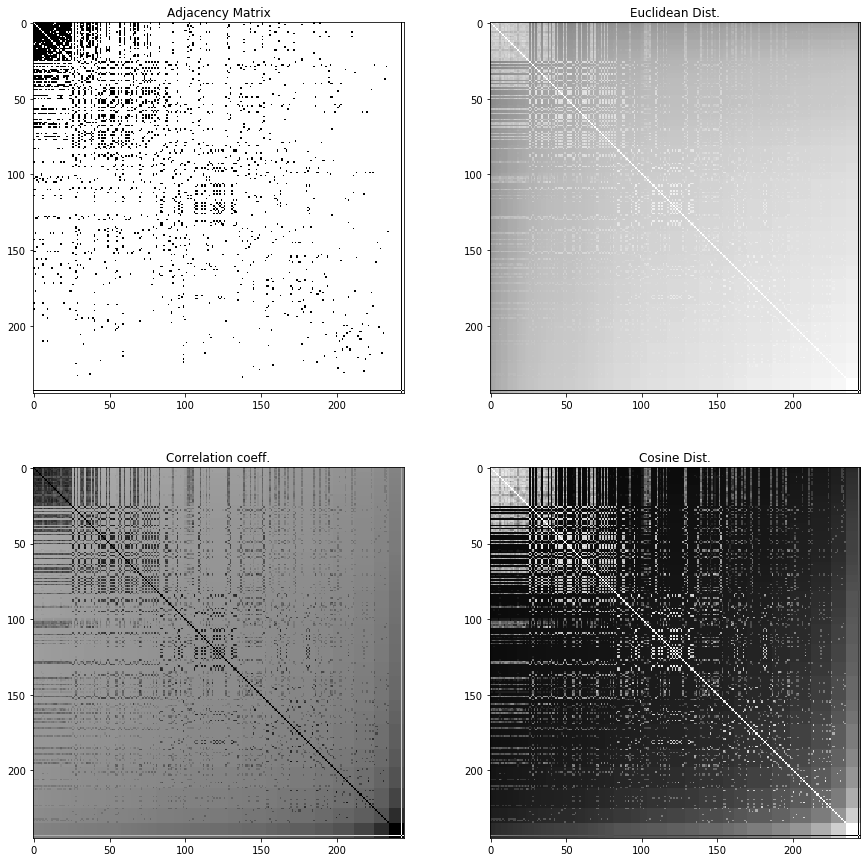

In [256]:
plotDist(A, figsize=(15,15))

## The closest random graph model similar to my SN

# Community Detection

## Clique search

## Best results of various community detection algorithms

## Incremental algorithms presented during classes

## Make results visible on the network layout or adjacency matrix picture